In [44]:
know_encodings =[]
know_names=[]

In [49]:
def add_person(img_name, person_name, person_id = len(know_encodings)):
    know_img = face_recognition.load_image_file(img_name)
    know_encoding = face_recognition.face_encodings(know_img)[0]
    
    know_names.append(person_name)
    know_encodings.append(know_encoding)
    

In [50]:
add_person('person1.jpg','Капитанов')

In [52]:
know_names


['Капитанов']

Дописать ниже сравнение с "эталонными фотками"

In [43]:
video_capture = cv2.VideoCapture(0)

while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    # Уменьшаем размер кадра для ускорения обработки (по желанию)
    small_frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)
    rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)

    # определяем координаты лица и их энкодинги
    face_locations = face_recognition.face_locations(rgb_small_frame)
    face_encodings = face_recognition.face_encodings(rgb_small_frame,face_locations)

    #обрабатываем изображение обратно
    face_locations = [(top*2, right*2, bottom*2, left*2) for (top, right, bottom, left) in face_locations]

    #рисуем прямоугольник
    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(frame,'face',(left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Отображаем кадр
    cv2.imshow('video', frame)

    # Выход по нажатию 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
              
# Освобождаем ресурсы
video_capture.release()
cv2.destroyAllWindows()


In [ ]:
#-----------------------

In [12]:
image = face_recognition.load_image_file("img2.jpg")
face_locations = face_recognition.face_locations(image)
print(face_locations)

[(345, 1017, 420, 942), (365, 315, 454, 225), (209, 410, 252, 367), (188, 83, 239, 31), (142, 405, 178, 369), (337, 152, 389, 101), (275, 792, 365, 703), (118, 309, 154, 273)]


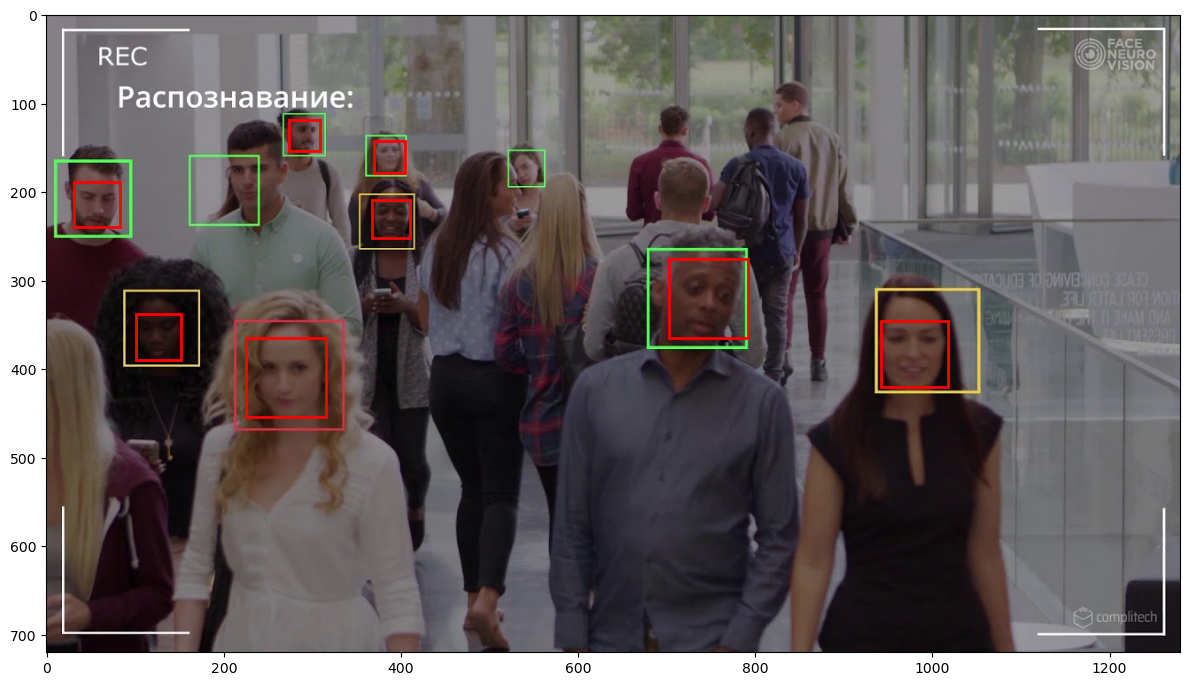

In [29]:
fig,ax = plt.subplots(1, figsize=(12,8))
ax.imshow(image)

for (top, right, bottom, left) in face_locations:
    rect = patches.Rectangle(
        (left, top),           
        right - left,          
        bottom - top,          
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [53]:
#---------------------

### GhostFaceNet 

In [80]:
import os
import cv2
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity

In [81]:
MODEL_PATH = 'checkpoints/GN_W1.3_S1_ArcFace_epoch46.h5'
EMBEDDINGS_FILE = 'saved_embeddings.pkl' # Кэш эмбеддингов
THRESHOLD = 0.4                                        
DATABASE_DIR = 'faces_database'  # фото людей (обработанные)
RAW_PHOTOS_DIR = 'raw_photos' #  исходные фото людей
OUTPUT_DIR = DATABASE_DIR # куда обработанные

INPUT_SIZE = (112, 112)
'''
Структура папок с фотками для эмбенлингов(RAW_PHOTOS_DIR):
 -Фамилия1 (id1)
     -фото1
     -фото2
     -фото3
 -Фамилия2 (id2)
     -фото1
     -фото2
и тп
'''

In [82]:
# проверка модели
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"модлеь не найдена: {MODEL_PATH}")
    
try:
    model = load_model(MODEL_PATH)
    print("модлеь загружена")

    # случайное изображение тест
    test_input = np.random.rand(1, 112, 112, 3).astype(np.float32)
    test_emb = model.predict(test_input, verbose=0)

    if np.any(np.isnan(test_emb)) or np.allclose(test_emb, 0):
        raise ValueError("модель выдаёт некорректные эмбеддинги")

    print(f"Модель работает: эмбеддинг (512,) = {test_emb.shape}")

except Exception as e:
    print(f"ошибка: {e}")
    raise

модлеь загружена
Модель работает: эмбеддинг (512,) = (1, 512)


## Функции

In [83]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

def prepare_and_convert_all_photos():
    """
    Рекурсивно проходит по папкам в raw_photos,
    изменяет размер на 112x112, конвертирует BGR в RGB,
    и сохраняет в faces_database с нумерацией
    """
    print(f"папка {RAW_PHOTOS_DIR}")

    if not os.path.exists(RAW_PHOTOS_DIR):
        raise FileNotFoundError(f"не найдено: {RAW_PHOTOS_DIR}")

    processed_count = 0

    for person_name in os.listdir(RAW_PHOTOS_DIR):
        person_path = os.path.join(RAW_PHOTOS_DIR, person_name)
        
        if not os.path.isdir(person_path):
            continue

        output_person_dir = os.path.join(OUTPUT_DIR, person_name)
        os.makedirs(output_person_dir, exist_ok=True)

        print(f"обработка: {person_name}")

        file_idx = 1

        for filename in os.listdir(person_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                input_path = os.path.join(person_path, filename)
                output_path = os.path.join(output_person_dir, f"{file_idx:03d}.jpg")

                try:
                    img = cv2.imread(input_path)
                    if img is None:
                        print(f"пропуск: {filename}")
                        continue

                    img_resized = cv2.resize(img, (112, 112))

                    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                    
                    cv2.imwrite(output_path, img_rgb)

                    print(f" {filename} → {output_path}")
                    processed_count += 1
                    file_idx += 1

                except Exception as e:
                    print(f"Ошибка при обработке {filename}: {e}")

    print(f"обработно {processed_count} фото в папку: {OUTPUT_DIR}")

# старт
prepare_and_convert_all_photos()

папка raw_photos
обработка: Diachenko
 d1.jpg → faces_database\Diachenko\001.jpg
 d2.jpg → faces_database\Diachenko\002.jpg
 d3.jpg → faces_database\Diachenko\003.jpg
 d4.jpg → faces_database\Diachenko\004.jpg
 WIN_20250910_13_53_56_Pro.jpg → faces_database\Diachenko\005.jpg
 WIN_20250910_13_53_57_Pro.jpg → faces_database\Diachenko\006.jpg
 WIN_20250910_13_53_59_Pro.jpg → faces_database\Diachenko\007.jpg
 WIN_20250910_13_54_01_Pro.jpg → faces_database\Diachenko\008.jpg
 WIN_20250910_13_54_04_Pro.jpg → faces_database\Diachenko\009.jpg
 WIN_20250910_13_54_05_Pro.jpg → faces_database\Diachenko\010.jpg
 WIN_20250910_13_54_07_Pro.jpg → faces_database\Diachenko\011.jpg
 WIN_20250910_13_54_08_Pro.jpg → faces_database\Diachenko\012.jpg
 WIN_20250910_13_54_10_Pro.jpg → faces_database\Diachenko\013.jpg
 WIN_20250910_13_54_14_Pro.jpg → faces_database\Diachenko\014.jpg
 WIN_20250910_13_54_15_Pro.jpg → faces_database\Diachenko\015.jpg
 WIN_20250910_13_54_16_Pro.jpg → faces_database\Diachenko\016.jp

In [84]:
def preprocess(img):
    """
    Подготавливает изображение для модели
    """
    img = cv2.resize(img, INPUT_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0  # [0, 255] → [0.0, 1.0]
    img = np.expand_dims(img, axis=0)  
    return img

In [85]:
def create_database(model, db_dir, cache_file):
    if os.path.exists(cache_file):
        print(f"загрузка кэша: {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)

    print(f"база из: {db_dir}")
    database = {}

    for person_name in os.listdir(db_dir):
        person_path = os.path.join(db_dir, person_name)
        if not os.path.isdir(person_path):
            continue

        print(f"обработка: {person_name}")
        embeddings = []

        for filename in os.listdir(person_path):
            filepath = os.path.join(person_path, filename)
            img = cv2.imread(filepath)
            if img is None:
                print(f"не загружено: {filename}")
                continue

            # Конвертируем BGR → RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Подготавливаем
            processed = preprocess(img_rgb)
            # Получаем эмбеддинг
            embedding = model.predict(processed, verbose=0)[0]
            embeddings.append(embedding)

        if embeddings:
            database[person_name] = embeddings
            print(f" {person_name}: {len(embeddings)} фото")

    # Сохраняем
    with open(cache_file, 'wb') as f:
        pickle.dump(database, f)
    print(f"база сохранена в {cache_file}")
    return database

# Создаём базу
database = create_database(model, DATABASE_DIR, EMBEDDINGS_FILE)

загрузка кэша: saved_embeddings.pkl


In [86]:
def recognize_with_fixed_roi(model, database, threshold=0.6):
    cap = cv2.VideoCapture(1)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    if not cap.isOpened():
        print("камера не доступна")
        return

    print("старт, 'q' для выхода")
    
    embedding_buffer = []

    # против зацикливания
    last_recognized = None
    cooldown_frames = 30
    cooldown_counter = 0

    # текущий результат
    current_name = "готово"
    current_sim = 0.0
    current_color = (200, 200, 200)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # зеркальное отражение
        frame = cv2.flip(frame, 1)

        h, w, _ = frame.shape
        face_w = 320
        face_h = 320
        x1 = (w - face_w) // 2
        y1 = (h - face_h) // 2
        x2 = x1 + face_w
        y2 = y1 + face_h

        face_img = frame[y1:y2, x1:x2]

        # проверка качества
        gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
        variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        if variance < 30:
            # Продолжаем показывать ПОСЛЕДНИЙ результат
            cv2.rectangle(frame, (x1, y1), (x2, y2), current_color, 2)
            cv2.putText(frame, f"{current_name} ({current_sim:.2f})", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, current_color, 2)
            cv2.imshow("Face Recognition", frame)
            continue

        face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        processed = preprocess(face_rgb)
        current_emb = model.predict(processed, verbose=0)[0]

        if cooldown_counter > 0:
            cooldown_counter -= 1

        # добавляем в буфер
        embedding_buffer.append(current_emb)

        # анализируем каждые 5 кадров
        if len(embedding_buffer) >= 5:
            avg_emb = np.mean(embedding_buffer, axis=0).reshape(1, -1)
            best_name = "Неизвестно"
            max_sim = 0.0

            for name, embs in database.items():
                sims = [cosine_similarity(avg_emb, [emb])[0][0] for emb in embs]
                avg_sim = np.mean(sims)
                if avg_sim > max_sim:
                    max_sim = avg_sim
                    if avg_sim >= threshold:
                        best_name = name

            # новый ли человек
            if best_name != last_recognized and cooldown_counter == 0:
                last_recognized = best_name
                cooldown_counter = cooldown_frames
                current_name = best_name
                current_sim = max_sim
                current_color = (0, 255, 0) if best_name != "неизвестно" else (0, 0, 255)
                print(f"распознано: {best_name} | схожесть: {max_sim:.2f}")

            # сбрасываем буфер
            embedding_buffer = []

        # текущий результат
        cv2.rectangle(frame, (x1, y1), (x2, y2), current_color, 2)
        cv2.putText(frame, f"{current_name} ({current_sim:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, current_color, 2)

        cv2.imshow("Face Recognition", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print("камера остановлена.")

## Запуск

In [87]:
model = load_model(MODEL_PATH)
print("модель загружена")

database = load_or_create_embeddings(model, DATABASE_DIR, EMBEDDINGS_FILE)

recognize_with_fixed_roi(model, database, THRESHOLD)

модель загружена
Загружаю эмбеддинги из saved_embeddings.pkl
старт, 'q' для выхода
распознано: Kapitanov | схожесть: 0.46
распознано: Diachenko | схожесть: 0.49
распознано: Kapitanov | схожесть: 0.61
камера остановлена.


In [88]:
# проверка на схожесть между двумя фотками
img1 = preprocess(cv2.cvtColor(cv2.imread('faces_database/Kapitanov/006.jpg'), cv2.COLOR_BGR2RGB))
img2 = preprocess(cv2.cvtColor(cv2.imread('faces_database/Diachenko/005.jpg'), cv2.COLOR_BGR2RGB))

emb1 = model.predict(img1)[0]
emb2 = model.predict(img2)[0]

sim = cosine_similarity([emb1], [emb2])[0][0]
print(f"схожесть: {sim:.3f}")

схожесть: 0.521
